In [2]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

dog.jpg


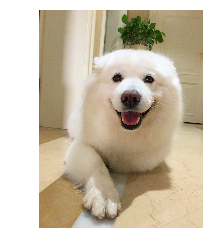

Samoyed, Samoyede - score: 0.5893775820732117
Pomeranian - score: 0.06851781159639359
keeshond - score: 0.020125795155763626
chow, chow chow - score: 0.006170067936182022
toy poodle - score: 0.0032433655578643084

rabbit.jpg


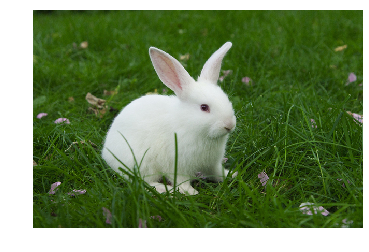

hare - score: 0.4913904070854187
wood rabbit, cottontail, cottontail rabbit - score: 0.3651581406593323
Angora, Angora rabbit - score: 0.08049188554286957
guinea pig, Cavia cobaya - score: 0.0007025526138022542
cellular telephone, cellular phone, cellphone, cell, mobile phone - score: 0.0005248304805718362

dolphin.jpg


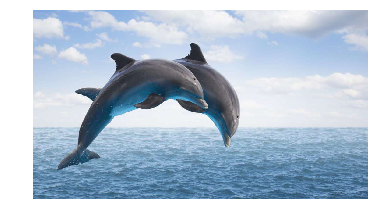

killer whale, killer, orca, grampus, sea wolf, Orcinus orca - score: 0.4154411554336548
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias - score: 0.12717658281326294
tiger shark, Galeocerdo cuvieri - score: 0.11174960434436798
hammerhead, hammerhead shark - score: 0.03674209117889404
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus - score: 0.018552258610725403

tiger.jpg


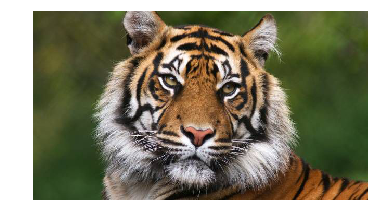

tiger, Panthera tigris - score: 0.7168012261390686
tiger cat - score: 0.21314258873462677
lynx, catamount - score: 0.000963460945058614
zebra - score: 0.0007166415452957153
sweatshirt - score: 0.00041914224857464433

panda.jpg


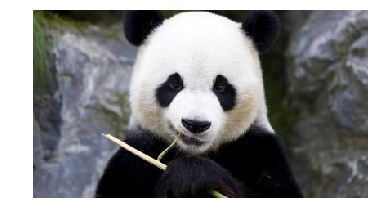

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca - score: 0.892472505569458
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens - score: 0.0035428772680461407
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus - score: 0.0010300060966983438
earthstar - score: 0.0009216384496539831
American black bear, black bear, Ursus americanus, Euarctos americanus - score: 0.0008334850426763296

squirrel.jpg


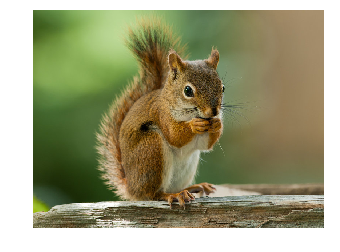

fox squirrel, eastern fox squirrel, Sciurus niger - score: 0.9581642150878906
throne - score: 0.0017132741631940007
studio couch, day bed - score: 0.001236720010638237
ear, spike, capitulum - score: 0.0010133953765034676
marmot - score: 0.00046522077172994614

cat.jpg


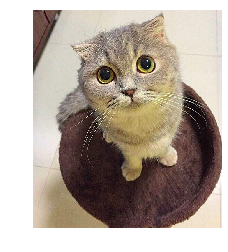

Persian cat - score: 0.8703399300575256
tabby, tabby cat - score: 0.017822060734033585
lynx, catamount - score: 0.0041532739996910095
Egyptian cat - score: 0.001532260561361909
drum, membranophone, tympan - score: 0.0015291519230231643



In [3]:
class NodeLookUp(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        
    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符串n********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        # 一行一行读取数据
        for line in proto_as_ascii_lines:
            # 去掉换行符
            line = line.strip('\n')
            # 按照'\t'分割
            parsed_items = line.split('\t')
            # 获取分类编号
            uid = parsed_items[0]
            # 获取分类名称
            human_string = parsed_items[1]
            # 保存编号字符串n******与分类名称映射关系
            uid_to_human[uid] = human_string
            
        
        # 加载分类字符串n******对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            if line.startswith("  target_class:"):
                # 获取分类编号1-1000
                target_class = int(line.split(': ')[1])
            if line.startswith("  target_class_string:"):
                # 过去编号字符串n******
                target_class_string = line.split(': ')[1]
                # 保存分类编号1-1000余编号字符串n******映射关系
                node_id_to_uid[target_class] = target_class_string[1:-2]
                
        # 建立分类编号1-1000对应分类名称的映射关系
        node_id_to_name = {}
        for key, value in node_id_to_uid.items():
            # 获取分类名称
            name = uid_to_human[value]
            # 建立分类编号1-1000道分类名称的映射关系
            node_id_to_name[key] = name
        
        return node_id_to_name
    
    # 传入分类编号1-1000返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]
    
# 创建一个图了来存放google训练好的模型
with tf.gfile.GFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')
    
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    # 遍历目录
    for root, dirs, files in os.walk('./images/'):
        for file in files:
            # 先判断文件格式是否是图片格式
            if file.split('.')[-1] in ["jpg", "jpeg", "png", "gif"]:
                # 载入图片
                image_data = tf.gfile.GFile(os.path.join(root, file), 'rb').read()
                predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data}) # 图片格式是jpg
                predictions = np.squeeze(predictions) # 将结果转换为1维数据

                # 打印图片路径及名称
                image_path = os.path.join(root, file)
                print(file)
                # 显示图片
                img = Image.open(image_path)
                plt.imshow(img)
                plt.axis('off')
                plt.show()

                # 排序
                top_k = predictions.argsort()[-5:][::-1]
                node_lookup = NodeLookUp()
                for node_id in top_k:
                    # 获取分类名称
                    human_string = node_lookup.id_to_string(node_id)
                    # 获取该分类的置信度
                    score = predictions[node_id]

                    print("{} - score: {}".format(human_string, score))
                print()